# Univariate GANs for financial time series with GMM and relativistic losses


In [440]:
import numpy as np
import matplotlib.pyplot as plt

In [441]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Activation
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import Progbar

from keras.layers import Lambda, Concatenate

from time import time

import datetime

import sys
import os
import pickle


In [442]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()


In [443]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [444]:
import pandas as pd
mydata=pd.read_csv("/Users/user/Documents/Cours/CentraleSupelec/Deep Learning in Finance/TD4/sp500_20161229.csv")
mydata.dropna(inplace=True)

rets=np.hstack(mydata.values[:,1:].T)
rets=rets.astype(float)
rets=rets[np.isfinite(rets)]

In [445]:
T=1000
num_GMMs=6
dim_noise=5000
nu=3

INIT_LR = 1e-5
bias=False
activation_generator="selu"
activation_discriminator="PReLU"

num_epochs= 200 #500
batch_size=50
num_batches_per_epoch=int(len(rets)/batch_size)
losses=[]

generator_type="Dense"

In [446]:
n_samples_data=10000
#t0s=np.random.choice(len(rets)-T,size=n_samples_data)

rets_sample=[rets[range(i,i+T)] for i in np.random.choice(len(rets)-T,size=n_samples_data)]
X=np.array(rets_sample)         # list -> 2d-array

# X = scaler.fit_transform(X)
X.shape

(10000, 1000)

### Avant d'essayer d'apprendre des faits stylisés comme le clustering de volatilité ou la distribution à queues lourdes des log rendements essayons d'abord avec des statistiques plus simples.

In [447]:
import tensorflow_probability as tfp

def compute_GMM(X):
     ## FILL THIS !!!
     ## statsmodels and numpy are not allowed, only tf.something
     mean_ = tf.math.reduce_mean(X, axis=0, keepdims=True, name=None)
     std_ = tf.math.reduce_std(X, axis=0, keepdims=True, name=None)
     max_ = tf.math.reduce_max(X, axis=0, keepdims=True, name=None)
     #return mean
     gmm_output = tf.concat([mean_, std_, max_], axis=-1)

     return gmm_output


In [448]:
import tensorflow.keras.backend as K

def relativistic_average(input_):
    x_0 = input_[0]
    x_1 = input_[1]
    return x_0 - K.mean(x_1, axis=0)

LOSS='binary_crossentropy'
OPT = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, beta_1=0.8, beta_2=0.995)

INIT_LR_gen = 1e-5
INIT_LR_dis = INIT_LR_gen / 10
OPT_gen = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR_gen, beta_1=0.8, beta_2=0.995)
OPT_dis = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR_dis, beta_1=0.8, beta_2=0.995)


In [449]:
def generator_builder(T,dim_noise,activation="relu",use_bias=True):
    ## FILL THIS !!!
    input_noise = Input(shape=(dim_noise,))

    x_first = Dense(dim_noise, activation=activation, use_bias=use_bias)(input_noise)
    x_second = Dense(10, activation=activation, use_bias=use_bias)(x_first)
    x_third = Dense(100, activation=activation, use_bias=use_bias)(x_second)
    x_fourth = Dense(50, activation=activation, use_bias=use_bias)(x_third)
    x_fifth = Dense(10, activation=activation, use_bias=use_bias)(x_fourth)
    x_sixth = Dense(1, activation=activation, use_bias=use_bias)(x_fifth)
    generator_output = Dense(T, activation='tanh', use_bias=use_bias)(x_sixth) 

    generator = Model(inputs=input_noise, outputs=generator_output)

    return generator

def discriminator_builder(num_GMMs, T, activation="relu", use_bias=True):
    ## FILL THIS !!!
    input_layer = Input(shape=(T,))

    ## Call compute_GMM
    lambda_layer = Lambda(compute_GMM)(input_layer)
    
    x_first = Dense(10, activation=activation, use_bias=use_bias)(lambda_layer)
    x_second = Dense(100, activation=activation, use_bias=use_bias)(x_first)
    x_third = Dense(50, activation=activation, use_bias=use_bias)(x_second)
    x_fourth = Dense(10, activation=activation, use_bias=use_bias)(x_third)
    discriminator_output_branch1 = Dense(1, activation='linear', use_bias=use_bias)(x_fourth)

    discriminator_output_branch2 = Dense(1, activation='linear', use_bias=use_bias)(lambda_layer)

    concatenated_outputs = Concatenate()([discriminator_output_branch1, discriminator_output_branch2])

    final_output = Dense(1, activation='tanh', use_bias=use_bias)(concatenated_outputs)

    discriminator = Model(inputs=input_layer, outputs=final_output)

    return discriminator


discriminator=discriminator_builder(num_GMMs,T,use_bias=bias,activation=activation_discriminator)
generator    =generator_builder(T,dim_noise,use_bias=bias,activation=activation_generator)

In [450]:
discriminator.compile(OPT_dis, loss=LOSS)
discriminator.build(input_shape=(2*batch_size,T))
discriminator.summary()

Model: "model_120"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_128 (InputLayer)      [(None, 1000)]               0         []                            
                                                                                                  
 lambda_36 (Lambda)          (1, 3000)                    0         ['input_128[0][0]']           
                                                                                                  
 dense_304 (Dense)           (1, 10)                      30010     ['lambda_36[0][0]']           
                                                                                                  
 dense_305 (Dense)           (1, 100)                     1100      ['dense_304[0][0]']           
                                                                                          

In [451]:


Real_data                          = Input(shape=X.shape[1:])
Noise_input                        = Input(shape=(dim_noise))

Fake_data                          = generator(Noise_input)
Discriminator_real_out             = discriminator(Real_data)
Discriminator_fake_out             = discriminator(Fake_data)
Real_Fake_relativistic_average_out = Lambda(relativistic_average, name='Real_minus_mean_fake')([Discriminator_real_out, Discriminator_fake_out])
Fake_Real_relativistic_average_out = Lambda(relativistic_average, name='Fake_minus_mean_real')([Discriminator_fake_out, Discriminator_real_out])

Real_Fake_relativistic_average_out = Activation('sigmoid')(Real_Fake_relativistic_average_out)
Fake_Real_relativistic_average_out = Activation('sigmoid')(Fake_Real_relativistic_average_out)

In [452]:
Discriminator_Relativistic_out = Concatenate()([Real_Fake_relativistic_average_out, Fake_Real_relativistic_average_out])

generator_train = Model([Noise_input, Real_data], Discriminator_Relativistic_out)
discriminator.trainable=False
generator_train.compile(OPT_gen, loss=LOSS)
generator_train.summary()
#SVG(model_to_dot(generator_train, show_shapes=True).create(prog='dot', format='svg'))

Model: "model_122"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_131 (InputLayer)      [(None, 5000)]               0         []                            
                                                                                                  
 input_130 (InputLayer)      [(None, 1000)]               0         []                            
                                                                                                  
 model_121 (Functional)      (None, 1000)                 2505751   ['input_131[0][0]']           
                                                          0                                       
                                                                                                  
 model_120 (Functional)      (1, 1)                       39682     ['input_130[0][0]',   

In [453]:
discriminator_train = Model([Noise_input, Real_data],Discriminator_Relativistic_out)
generator.trainable = False
discriminator.trainable=True
discriminator_train.summary()
discriminator_train.compile(OPT_dis, loss=LOSS)
#SVG(model_to_dot(discriminator_train, show_shapes=True).create(prog='dot', format='svg'))

Model: "model_123"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_131 (InputLayer)      [(None, 5000)]               0         []                            
                                                                                                  
 input_130 (InputLayer)      [(None, 1000)]               0         []                            
                                                                                                  
 model_121 (Functional)      (None, 1000)                 2505751   ['input_131[0][0]']           
                                                          0                                       
                                                                                                  
 model_120 (Functional)      (1, 1)                       39682     ['input_130[0][0]',   

In [454]:
true_y = np.ones((batch_size, 1), dtype=np.float32)
fake_y = np.zeros((batch_size, 1), dtype=np.float32)
y_for_dis = np.concatenate((true_y, fake_y), axis=1)
y_for_gen = np.concatenate((fake_y, true_y), axis=1)




TRAINING_RATIO=1

discriminator_loss=[]
generator_loss=[]
discriminator_loss_epoch = []
generator_loss_epoch = []

In [455]:
for epoch in range(num_epochs):

    np.random.shuffle(X)

    print("epoch {} of {}".format(epoch+1, num_epochs))
    num_batches = int(X.shape[0] // batch_size)
    minibatches_size = batch_size * (TRAINING_RATIO+1)
    print("number of batches: {}".format(int(X.shape[0] // (minibatches_size))))
    print("minibatches_size: "+str(minibatches_size))
    print("num_batches "+str(num_batches))

    progress_bar = Progbar(target=int(X.shape[0] // minibatches_size))

    start_time = time()
    for index in range(int(X.shape[0] // (minibatches_size))):
        progress_bar.update(index)
        iteration_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]

        for j in range(TRAINING_RATIO):
            data_batch = iteration_minibatches[j * batch_size : (j + 1) * batch_size]
            noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(discriminator_train.train_on_batch([noise, data_batch],y_for_dis))

        data_batch = iteration_minibatches[TRAINING_RATIO*batch_size : (TRAINING_RATIO + 1) * batch_size]
        noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(generator_train.train_on_batch([noise, data_batch], y_for_gen))

    discriminator_loss_epoch.append(np.mean(discriminator_loss[-int(X.shape[0] // (minibatches_size)):]))
    generator_loss_epoch.append(np.mean(generator_loss[-TRAINING_RATIO:]))
    print("\nLoss discriminator ", discriminator_loss_epoch[-1])
    print("Loss generator ", generator_loss_epoch[-1])
    print('\nepoch time: {}'.format(time()-start_time))
    
    test_noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)

    generated_data = generator.predict(test_noise)


epoch 1 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.7038277417421341
Loss generator  0.5556437373161316

epoch time: 7.825361013412476
2/2 [==============================] - 0s 7ms/step
epoch 2 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.7074492847919465
Loss generator  0.7186384797096252

epoch time: 6.791686058044434
2/2 [==============================] - 0s 7ms/step
epoch 3 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.7291221916675568
Loss generator  0.6194016337394714

epoch time: 6.7524573802948
2/2 [==============================] - 0s 7ms/step
epoch 4 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.7410

2/2 [==============================] - 0s 7ms/step
epoch 30 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2372297525405884
Loss generator  0.31556928157806396

epoch time: 6.984602212905884
2/2 [==============================] - 0s 7ms/step
epoch 31 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2423269069194793
Loss generator  0.34030386805534363

epoch time: 7.1135642528533936
2/2 [==============================] - 0s 7ms/step
epoch 32 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2390873324871063
Loss generator  0.37254825234413147

epoch time: 7.002755641937256
2/2 [==============================] - 0s 7ms/step
epoch 33 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [=======

2/2 [==============================] - 0s 9ms/step
epoch 59 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.3020563745498657
Loss generator  0.28907376527786255

epoch time: 7.732217788696289
2/2 [==============================] - 0s 7ms/step
epoch 60 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2948047757148742
Loss generator  0.3347342014312744

epoch time: 8.05667495727539
2/2 [==============================] - 0s 11ms/step
epoch 61 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2966250884532928
Loss generator  0.325056791305542

epoch time: 7.859673976898193
2/2 [==============================] - 0s 7ms/step
epoch 62 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [===========

2/2 [==============================] - 0s 7ms/step
epoch 88 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.268312007188797
Loss generator  0.2930377125740051

epoch time: 7.9069859981536865
2/2 [==============================] - 0s 9ms/step
epoch 89 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2607836246490478
Loss generator  0.325775682926178

epoch time: 8.93982720375061
2/2 [==============================] - 0s 8ms/step
epoch 90 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2635516977310182
Loss generator  0.36022162437438965

epoch time: 8.288820028305054
2/2 [==============================] - 0s 7ms/step
epoch 91 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============

2/2 [==============================] - 0s 7ms/step
epoch 117 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2017086362838745
Loss generator  0.32582178711891174

epoch time: 7.757719993591309
2/2 [==============================] - 0s 7ms/step
epoch 118 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2072049915790557
Loss generator  0.3318815231323242

epoch time: 7.610198974609375
2/2 [==============================] - 0s 7ms/step
epoch 119 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.1977401399612426
Loss generator  0.3578873872756958

epoch time: 7.6769630908966064
2/2 [==============================] - 0s 8ms/step
epoch 120 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [=====

2/2 [==============================] - 0s 8ms/step
epoch 146 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.1336232256889343
Loss generator  0.3289192318916321

epoch time: 7.540648937225342
2/2 [==============================] - 0s 7ms/step
epoch 147 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.1235359781980514
Loss generator  0.4200338125228882

epoch time: 7.469002962112427
2/2 [==============================] - 0s 7ms/step
epoch 148 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.1139151757955552
Loss generator  0.43298956751823425

epoch time: 7.723324775695801
2/2 [==============================] - 0s 7ms/step
epoch 149 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [======

2/2 [==============================] - 0s 7ms/step
epoch 175 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.0328887367248536
Loss generator  0.3976706266403198

epoch time: 7.4594480991363525
2/2 [==============================] - 0s 7ms/step
epoch 176 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.0290024596452714
Loss generator  0.418755441904068

epoch time: 7.455265045166016
2/2 [==============================] - 0s 7ms/step
epoch 177 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.03070150077343
Loss generator  0.4465443789958954

epoch time: 7.449342966079712
2/2 [==============================] - 0s 7ms/step
epoch 178 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [=========

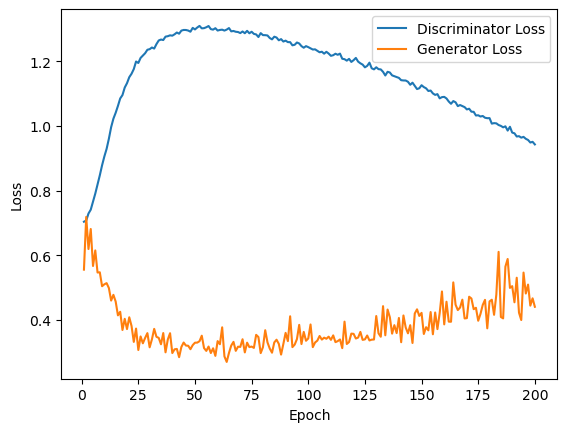

In [456]:
plt.plot(range(1, len(discriminator_loss_epoch)+1), discriminator_loss_epoch, label='Discriminator Loss')
plt.plot(range(1, len(generator_loss_epoch)+1), generator_loss_epoch, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


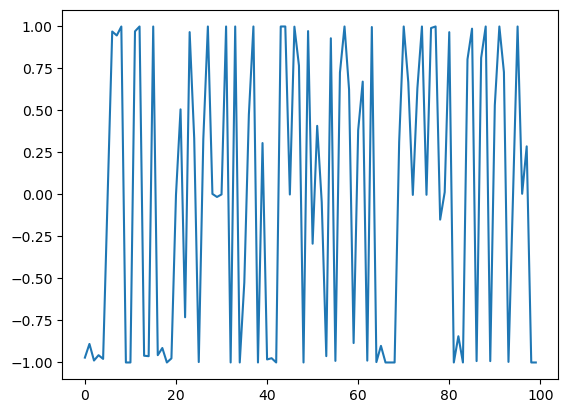

In [459]:
plt.plot(generated_data[0][:100])

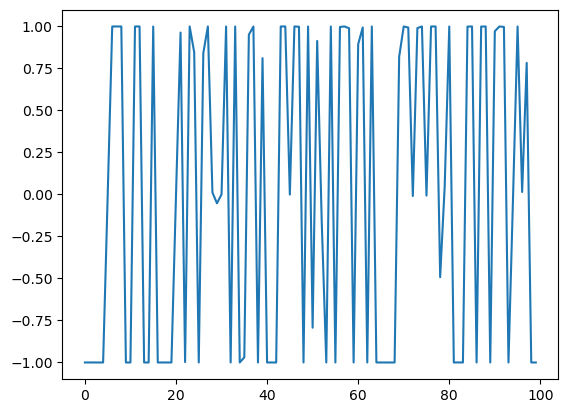

In [465]:
plt.plot(generated_data[1][:100])

In [461]:
print(np.shape(generated_data))
print(np.shape(X))

(50, 1000)
(10000, 1000)


In [462]:
mean_ = 0
var_ = 0
max_ = 0
for i in range(len(test_noise)):
  mean_ +=np.mean(test_noise[i])
  var_ +=np.var(test_noise[i])
  max_ +=np.max(test_noise[i])
print("Test noise")
print("mean of means", str(mean_/len(test_noise)))
print("mean of vars", str(var_/len(test_noise)))
print("mean of maxs", str(max_/len(test_noise)))

Test noise
mean of means -0.00536418404051087
mean of vars 1.001296029648538
mean of maxs 14.958468634040724


In [463]:
mean_ = 0
var_ = 0
max_ = 0
for i in range(len(generated_data)):
  mean_ +=np.mean(generated_data[i])
  var_ +=np.var(generated_data[i])
  max_ +=np.max(generated_data[i])
print("Generated Data")
print("mean of means", str(mean_/len(generated_data)))
print("mean of vars", str(var_/len(generated_data)))
print("mean of maxs", str(max_/len(generated_data)))

Generated Data
mean of means -0.0074501129717100415
mean of vars 0.3721801210194826
mean of maxs 0.6926006889343261


In [464]:
mean_ = 0
var_ = 0
max_ = 0
for i in range(len(X)):
  mean_ +=np.mean(X[i])
  var_ +=np.var(X[i])
  max_ +=np.max(X[i])
print("X Data")
print("mean of means", str(mean_/len(X)))
print("mean of vars", str(var_/len(X)))
print("mean of maxs", str(max_/len(X)))

X Data
mean of means 0.0014186017104934748
mean of vars 0.002146001023247906
mean of maxs 0.3825195540851543


Le GAN a bien un impact sur les faits stylisés indiqués en rapprochant les faits stylisés d'intérêts du bruit en entrée aux faits stylisés des données d'entraînement X.

## Ici l'idée est d'étudier si la convergence des pertes des deux parties du GANs implique une meilleure reproduction des faits stylisés. En théorie, avec une convergence propre du GAN, il suffirait de faire tourner le code et d'arrêter l'execution lors du croisement des deux loss. Nous allons essayé de faire cela en "accélérant" l'apprentissage des deux parties.


In [474]:
INIT_LR_gen = 1e-4
INIT_LR_dis = INIT_LR_gen / 10
OPT_gen = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR_gen, beta_1=0.8, beta_2=0.995)
OPT_dis = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR_dis, beta_1=0.8, beta_2=0.995)


In [475]:
discriminator=discriminator_builder(num_GMMs,T,use_bias=bias,activation=activation_discriminator)
generator    =generator_builder(T,dim_noise,use_bias=bias,activation=activation_generator)

In [476]:
discriminator.compile(OPT_dis, loss=LOSS)
discriminator.build(input_shape=(2*batch_size,T))


Real_data                          = Input(shape=X.shape[1:])
Noise_input                        = Input(shape=(dim_noise))

Fake_data                          = generator(Noise_input)
Discriminator_real_out             = discriminator(Real_data)
Discriminator_fake_out             = discriminator(Fake_data)
Real_Fake_relativistic_average_out = Lambda(relativistic_average, name='Real_minus_mean_fake')([Discriminator_real_out, Discriminator_fake_out])
Fake_Real_relativistic_average_out = Lambda(relativistic_average, name='Fake_minus_mean_real')([Discriminator_fake_out, Discriminator_real_out])

Real_Fake_relativistic_average_out = Activation('sigmoid')(Real_Fake_relativistic_average_out)
Fake_Real_relativistic_average_out = Activation('sigmoid')(Fake_Real_relativistic_average_out)

Discriminator_Relativistic_out = Concatenate()([Real_Fake_relativistic_average_out, Fake_Real_relativistic_average_out])

generator_train = Model([Noise_input, Real_data], Discriminator_Relativistic_out)
discriminator.trainable=False
generator_train.compile(OPT_gen, loss=LOSS)

discriminator_train = Model([Noise_input, Real_data],Discriminator_Relativistic_out)
generator.trainable = False
discriminator.trainable=True
discriminator_train.summary()
discriminator_train.compile(OPT_dis, loss=LOSS)

true_y = np.ones((batch_size, 1), dtype=np.float32)
fake_y = np.zeros((batch_size, 1), dtype=np.float32)
y_for_dis = np.concatenate((true_y, fake_y), axis=1)
y_for_gen = np.concatenate((fake_y, true_y), axis=1)


TRAINING_RATIO=1

discriminator_loss=[]
generator_loss=[]
discriminator_loss_epoch = []
generator_loss_epoch = []

Model: "model_131"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_139 (InputLayer)      [(None, 5000)]               0         []                            
                                                                                                  
 input_138 (InputLayer)      [(None, 1000)]               0         []                            
                                                                                                  
 model_129 (Functional)      (None, 1000)                 2505751   ['input_139[0][0]']           
                                                          0                                       
                                                                                                  
 model_128 (Functional)      (1, 1)                       39682     ['input_138[0][0]',   

In [477]:
num_epochs = 200

for epoch in range(num_epochs):

    np.random.shuffle(X)

    print("epoch {} of {}".format(epoch+1, num_epochs))
    num_batches = int(X.shape[0] // batch_size)
    minibatches_size = batch_size * (TRAINING_RATIO+1)
    print("number of batches: {}".format(int(X.shape[0] // (minibatches_size))))
    print("minibatches_size: "+str(minibatches_size))
    print("num_batches "+str(num_batches))

    progress_bar = Progbar(target=int(X.shape[0] // minibatches_size))

    start_time = time()
    for index in range(int(X.shape[0] // (minibatches_size))):
        progress_bar.update(index)
        iteration_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]

        for j in range(TRAINING_RATIO):
            data_batch = iteration_minibatches[j * batch_size : (j + 1) * batch_size]
            noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(discriminator_train.train_on_batch([noise, data_batch],y_for_dis))

        data_batch = iteration_minibatches[TRAINING_RATIO*batch_size : (TRAINING_RATIO + 1) * batch_size]
        noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(generator_train.train_on_batch([noise, data_batch], y_for_gen))

    discriminator_loss_epoch.append(np.mean(discriminator_loss[-int(X.shape[0] // (minibatches_size)):]))
    generator_loss_epoch.append(np.mean(generator_loss[-TRAINING_RATIO:]))
    print("\nLoss discriminator ", discriminator_loss_epoch[-1])
    print("Loss generator ", generator_loss_epoch[-1])
    print('\nepoch time: {}'.format(time()-start_time))

    test_noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)

    generated_data = generator.predict(test_noise)

epoch 1 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.101920831799507
Loss generator  0.2815881073474884

epoch time: 7.702255964279175
2/2 [==============================] - 0s 9ms/step
epoch 2 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2779835760593414
Loss generator  0.2959643602371216

epoch time: 6.928001165390015
2/2 [==============================] - 0s 7ms/step
epoch 3 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.2447312104701995
Loss generator  0.28471654653549194

epoch time: 7.005292654037476
2/2 [==============================] - 0s 7ms/step
epoch 4 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  1.21

2/2 [==============================] - 0s 7ms/step
epoch 30 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.7012473505735397
Loss generator  0.6923671960830688

epoch time: 6.788733005523682
2/2 [==============================] - 0s 7ms/step
epoch 31 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.7019701790809632
Loss generator  0.6662557721138

epoch time: 6.780375003814697
2/2 [==============================] - 0s 7ms/step
epoch 32 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.6999986249208451
Loss generator  0.6823419332504272

epoch time: 6.80803918838501
2/2 [==============================] - 0s 7ms/step
epoch 33 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [===============

2/2 [==============================] - 0s 14ms/step
epoch 59 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.6931757748126983
Loss generator  0.693145215511322

epoch time: 14.104872226715088
2/2 [==============================] - 0s 13ms/step
epoch 60 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.6931648492813111
Loss generator  0.6931459307670593

epoch time: 13.571100234985352
2/2 [==============================] - 0s 29ms/step
epoch 61 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.6931648260354996
Loss generator  0.6929365396499634

epoch time: 13.226124048233032
2/2 [==============================] - 0s 11ms/step
epoch 62 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [=====

2/2 [==============================] - 0s 9ms/step
epoch 88 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.6931472450494767
Loss generator  0.6931469440460205

epoch time: 11.87865686416626
2/2 [==============================] - 0s 32ms/step
epoch 89 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.6931471389532089
Loss generator  0.6931469440460205

epoch time: 11.219650030136108
2/2 [==============================] - 0s 11ms/step
epoch 90 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
Loss discriminator  0.6931470000743866
Loss generator  0.6931469440460205

epoch time: 11.098819017410278
2/2 [==============================] - 0s 9ms/step
epoch 91 of 200
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [=======

KeyboardInterrupt: 

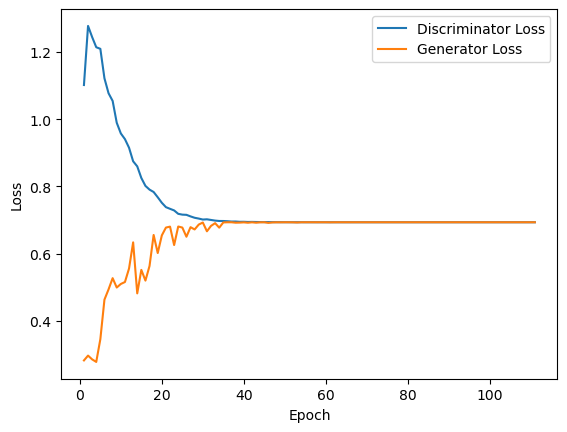

In [478]:
plt.plot(range(1, len(discriminator_loss_epoch)+1), discriminator_loss_epoch, label='Discriminator Loss')
plt.plot(range(1, len(generator_loss_epoch)+1), generator_loss_epoch, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [479]:
mean_ = 0
var_ = 0
max_ = 0
for i in range(len(test_noise)):
  mean_ +=np.mean(test_noise[i])
  var_ +=np.var(test_noise[i])
  max_ +=np.max(test_noise[i])
print("Test noise")
print("mean of means", str(mean_/len(test_noise)))
print("mean of vars", str(var_/len(test_noise)))
print("mean of maxs", str(max_/len(test_noise)))

Test noise
mean of means 0.005437988579517757
mean of vars 0.9445964308252138
mean of maxs 13.198687040616962


In [480]:
mean_ = 0
var_ = 0
max_ = 0
for i in range(len(generated_data)):
  mean_ +=np.mean(generated_data[i])
  var_ +=np.var(generated_data[i])
  max_ +=np.max(generated_data[i])
print("Generated Data")
print("mean of means", str(mean_/len(generated_data)))
print("mean of vars", str(var_/len(generated_data)))
print("mean of maxs", str(max_/len(generated_data)))

Generated Data
mean of means 0.0010834128407441312
mean of vars 0.08591522037226242
mean of maxs 0.3860997579991817


In [481]:
mean_ = 0
var_ = 0
max_ = 0
for i in range(len(X)):
  mean_ +=np.mean(X[i])
  var_ +=np.var(X[i])
  max_ +=np.max(X[i])
print("X Data")
print("mean of means", str(mean_/len(X)))
print("mean of vars", str(var_/len(X)))
print("mean of maxs", str(max_/len(X)))

X Data
mean of means 0.0014186017104934774
mean of vars 0.0021460010232479017
mean of maxs 0.3825195540851526


Nous remarquons par exemple que nous sommes sur un point de croisement des loss (à environ 0.7) et que les faits stylisés sont bien plus restranscris. Néanmoins, cela n'est pas forcément toujours le cas et il faudrait s'en assurer en entraînant plus longtemps le modèle mais cela peut nous donner une première approche des résultats.